# Parallelization

Due to the existence of the Global Interpreter Lock (GIL), LangGraph mainly implements **concurrency** rather than true multi-core parallelism. Considering that the [official documentation](https://docs.langchain.com/oss/python/langgraph/workflows-agents#parallelization) extensively uses the term parallelization, to maintain consistency with it, I will still use Parallelization as the title. However, except for the title, where it should be concurrency, I will express it as concurrency to avoid confusion for readers (￣O￣)ノ

This section introduces four ways to implement concurrency:

- Node Parallelism
- `@task` Decorator
- Map-reduce
- Sub-graphs

**Node Parallelism** achieves concurrency through parallel nodes; the **`@task` Decorator** declares functions as concurrent execution units; **Map-reduce** uses the Send function to concurrently send parameters to nodes for execution; **Sub-graphs** achieves concurrency through parallel sub-graphs. There's always a method that suits you.

> **Note**
> Knowledge Review: Concepts of `{underline}Process, Thread, Coroutine`
> - **Process**: The basic unit of operating system resource allocation, with independent memory space and file handles. For example, when you open WeChat, Chrome, each APP you open is a process. Processes are independent of each other, memory is not shared, so if one crashes, it doesn't affect others. However, process creation and switching costs are high because it requires preparing a complete set of resources (memory, file handles, etc.). Analogy: A process is like a house, each house has its own utilities.
> - **Thread**: An execution flow within a process, multiple threads share the same process's memory and resources. Because memory is shared, locks, synchronization, and race conditions need to be handled. Analogy: A house has many workers sharing the house's utilities. Each worker needs exclusive CPU core when working, but multiple workers can work simultaneously on different CPU cores.
> - **Coroutine**: A user-mode lightweight thread. Managed and scheduled by the program itself, not the operating system. It runs inside a thread and doesn't need to enter kernel mode when switching, so the overhead is extremely low. Uses cooperative scheduling, needs to actively yield execution rights when switching (e.g., `await`, `yield`). Because it can switch to execute other coroutines while waiting for I/O responses, it's very suitable for I/O-intensive scenarios, such as network requests, database operations, etc. Analogy: Workers can chop vegetables, steam rice during the gap of waiting for water to boil, without needing the boss (OS kernel) to assign tasks, can decide on their own, extremely efficient.

> **Note**
> Knowledge Review: Concepts of `{underline}Parallelism, Concurrency`
> - **Parallelism**: Multiple tasks truly execute simultaneously at the same moment, such as multi-core CPUs running multiple tasks together.
> - **Concurrency**: Multiple tasks execute alternately during the same time period, such as a single-core CPU alternating between running multiple programs through time-slice rotation.

In [1]:
import os
import time
import operator
import uuid

from dotenv import load_dotenv
from typing import Annotated
from datetime import datetime
from pydantic import BaseModel
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain.messages import HumanMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Send
from langgraph.func import entrypoint, task
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display
from concurrent.futures import ThreadPoolExecutor

# Load model configuration
_ = load_dotenv()

# Load model
model_name = "qwen3-max"
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model=model_name,
    temperature=0.7,
)

## 1. Node Parallelism

Node parallelism is easy to implement, just use `StateGraph` to create a workflow with concurrent nodes.

Below is a simple example of node parallelism. You can observe the timestamps of node execution to confirm whether they are truly running concurrently.

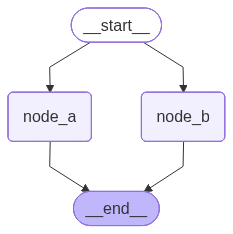

In [2]:
# Create concurrent node a
def node_a(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_a] Enter function time: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # Use sleep to simulate time consumption
    time.sleep(2)

    end_time = datetime.now()
    print(f"[node_a] Exit function time: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'Node a ran for {round((end_time - start_time).total_seconds(), 3)} seconds'
    )]}

# Create concurrent node b
def node_b(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_b] Enter function time: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # Use sleep to simulate time consumption
    time.sleep(4)

    end_time = datetime.now()
    print(f"[node_b] Exit function time: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'Node b ran for {round((end_time - start_time).total_seconds(), 3)} seconds'
    )]}

# Create graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node('node_a', node_a)
builder.add_node('node_b', node_b)

# Add edges
builder.add_edge(START, 'node_a')
builder.add_edge(START, 'node_b')
builder.add_edge('node_a', END)
builder.add_edge('node_b', END)

# Compile graph
my_graph = builder.compile(name='my-graph')
my_graph

In [3]:
# Invoke graph
response = my_graph.invoke({
    'messages': [HumanMessage(content='Execute node_a and node_b')]
})

for message in response['messages']:
    message.pretty_print()

[node_a] Enter function time: 2026-02-14 18:41:09.896
[node_b] Enter function time: 2026-02-14 18:41:09.897
[node_a] Exit function time: 2026-02-14 18:41:11.901
[node_b] Exit function time: 2026-02-14 18:41:13.902
================================ Human Message =================================

Execute node_a and node_b
================================ Human Message =================================

Node a ran for 2.005 seconds
================================ Human Message =================================

Node b ran for 4.005 seconds


> **Note**
> 
> To learn more details about node execution order, it is recommended to read [parallelization.ipynb](https://github.com/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb).

## 2. `@task` Decorator

The `@task` decorator declares the `generate_paragraph` function as a concurrent execution unit. Calling this function returns a future object. The workflow entry function defined by the `@entrypoint` decorator can concurrently call multiple `generate_paragraph` functions and collect the returned future objects.

In [4]:
# Concurrent execution unit
@task
def generate_paragraph(topic: str) -> str:
    response = llm.invoke([
        {"role": "system", "content": "You are an intelligent assistant who can write popular science articles"},
        {"role": "user", "content": (
            f"Write a paragraph about {topic}, approximately 100 words. "
            "What you write is just one paragraph of the entire article, "
            "so please focus on the given topic without introductory text")}
    ])
    return response.content

# Create persistent checkpoint
checkpointer = InMemorySaver()

# Workflow entry function, can concurrently call functions decorated by @task
@entrypoint(checkpointer=checkpointer)
def workflow(topics: list[str]) -> str:
    # Distribute topics to multiple task nodes for concurrent execution
    futures = [generate_paragraph(topic) for topic in topics]
    paragraphs = [f.result() for f in futures]
    return "\n\n".join(paragraphs)

# Run workflow
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
result = workflow.invoke(["What is sea urchin tofu", "How delicious is sea urchin tofu", "Ingredients and preparation of sea urchin tofu"], config=config)
print(result)

Sea urchin tofu, known as *uni tofu* in Japanese cuisine, is a delicate and luxurious dish that combines the creamy, briny richness of fresh sea urchin roe (uni) with the subtle softness of silken tofu. Unlike traditional tofu made solely from soybeans, this version often incorporates uni directly into the tofu mixture or serves it as a topping, creating a harmonious blend of oceanic umami and smooth, custard-like texture. It’s typically enjoyed chilled, garnished with a touch of soy sauce, grated ginger, or chives to enhance its natural flavors without overpowering them. Prized for its refined taste and elegant presentation, sea urchin tofu is a specialty found in high-end Japanese restaurants and reflects the culinary art of balancing simplicity with premium ingredients.

Sea urchin tofu is a luxurious umami bomb that marries the creamy, briny richness of fresh uni with the delicate, silken texture of chilled tofu. The sea urchin melts slightly upon contact, infusing the tofu with a 

### 3.1 Create Context Schema

In [5]:
# Roles
class Roles(BaseModel):
    roles: list[str]

# Single role
class Role(BaseModel):
    role: str

# Single response
class Response(BaseModel):
    response: str

# Best response ID
class BestResponse(BaseModel):
    id: int

# Global context
class Overall(TypedDict):
    roles: list[str]
    responses: Annotated[list, operator.add]
    best_response: str

### 3.2 Create Prompt Templates

In [6]:
# Role prompt
role_prompt = "The goddess hasn't replied to your message again. As a {role}, how should you reply to the goddess in one sentence? Please return in JSON format with a response field"

# Best response prompt
best_response_prompt = """Below are reactions from several types of guys when the goddess doesn't reply to their messages.
Which reply do you think can best win back the goddess's heart? Please return the corresponding ID.
Note that the first reaction corresponds to ID 0. Return in JSON format with an id field.
Here are the guys' reactions:

{responses}"""

### 3.3 Create Nodes

The magic here is that we use the [Send](https://docs.langchain.com/oss/python/langgraph/graph-api#send) function to distribute roles to the `generate_response` node for role response generation.

In [7]:
# [MAP] Use Send function to distribute roles
def continue_to_responses(state: Overall):
    return [ Send("generate_response", {"role": r}) for r in state["roles"] ]

# [MAP] Role response node: generate response for each role
def generate_response(state: Role):
    prompt = role_prompt.format(role=state["role"])
    response = llm.with_structured_output(Response).invoke(prompt)
    return {"responses": [response.response]}

# [REDUCE] Best response node: return the best response
def best_response(state: Overall):
    responses = "\n\n".join(state["responses"])
    prompt = best_response_prompt.format(responses=responses)
    response = llm.with_structured_output(BestResponse).invoke(prompt)
    return {"best_response": state["responses"][response.id]}

### 3.4 Compile Graph

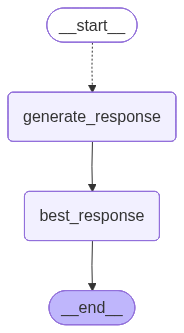

In [8]:
# Define Doge sub-graph output Schema
class DogeOutput(TypedDict):
    roles: list[str]
    responses: list[str]
    best_response: str

# Create graph
doge_builder = StateGraph(Overall, output_schema=DogeOutput)

# Add nodes
doge_builder.add_node("generate_response", generate_response)
doge_builder.add_node("best_response", best_response)

# Add edges
doge_builder.add_conditional_edges(START, continue_to_responses, ["generate_response"])
doge_builder.add_edge("generate_response", "best_response")
doge_builder.add_edge("best_response", END)

# Compile graph
doge_graph = doge_builder.compile(name='best-response')
doge_graph

In [9]:
# Invoke graph
roles = ["Dream Guy", "Troll", "Lovestruck Puppy", "Playboy", "Baby-faced Brother", "Socially Anxious Homebody",
         "Dominant CEO", "Tea-themed Guy 💅💅💅", "Artsy Long-haired Guy", "Kawaii Otaku"]
response = doge_graph.invoke({"roles": roles})

In [10]:
# Best response
print(f"Most liked reply by {model_name}: {response['best_response']}")

Most liked reply by qwen3-max: I hope I didn’t say anything awkward—just wanted to check in gently, no rush at all to reply!


In [11]:
# All responses
for role, resp in zip(response["roles"], response["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【Dream Guy】
Even in silence, your presence lingers like stardust in my dreams—shall I keep waiting, or shall I dream us a new beginning?

【Troll】
Oh mighty goddess, your silence is so divine—must be why even my trolls bow in awe... or maybe you're just buffering?

【Lovestruck Puppy】
My heart pines for your words like a lost puppy beneath a moonless sky—will you grace me with just a whisper?

【Playboy】
Guess even goddesses need a little more charm to keep them replying—shall I try again with a wink and a better line?

【Baby-faced Brother】
Goddess, your silence is more enchanting than words—but I’ll keep waiting, just in case you’re testing my devotion.

【Socially Anxious Homebody】
I hope I didn’t say anything awkward—just wanted to check in gently, no rush at all to reply!

【Dominant CEO】
I expect a reply by sunset—my patience, like my empire, has limits.

【Tea-themed Guy 💅💅💅】
Darling, even the finest loose-leaf needs time to steep—shall I brew another cup while we wait for your divine 

### 4.1 Create a Workflow

Below we create a workflow. Unlike `doge_graph` which requires specifying personas, it can automatically generate `n` new personas and generate responses for these personas.

In [12]:
# Define ReAct sub-graph global Schema
class ReActState(TypedDict):
    roles: list[str]
    n: int
    new_roles: list[str]
    responses: list[str]

# Divergently generate roles
def generate_roles(state: ReActState):
    roles = ", ".join(state["roles"])
    n = state["n"]
    prompt = (
        "Now we're playing a role-playing game about: how to win back the goddess when she doesn't reply to messages. "
        f"Reference role list: {roles}, create {n} different roles. "
        "You will play these roles later to reply to the goddess. "
        "Please return in JSON format with a roles field. "
        f"The roles field must be a pure string array with elements being the {n} newly created role names. "
        "Only return a JSON object without any explanation or other text."
    )
    res = llm.with_structured_output(Roles).invoke(prompt)
    return {"new_roles": res.roles}

def role_response(role: str) -> str:
    prompt = role_prompt.format(role=role)
    res = llm.with_structured_output(Response).invoke(prompt)
    return res.response

def divergent_thinking(state: ReActState):
    with ThreadPoolExecutor(max_workers=8) as executor:
        rs = list(executor.map(role_response, state["new_roles"]))
    return {"responses": rs}

> **Note**
> It feels like LangGraph makes concurrency more complicated. Writing it with [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) might be simpler.

Connect the nodes above to form a workflow.

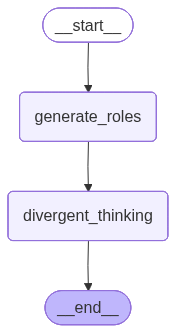

In [13]:
# Define ReAct sub-graph output Schema
class ReActOutput(TypedDict):
    new_roles: list[str]
    responses: list[str]

# Create graph
react_builder = StateGraph(
    state_schema=ReActState,
    output_schema=ReActOutput
)

# Add nodes
react_builder.add_node('generate_roles', generate_roles)
react_builder.add_node('divergent_thinking', divergent_thinking)

# Add edges
react_builder.add_edge(START, 'generate_roles')
react_builder.add_edge('generate_roles', 'divergent_thinking')
react_builder.add_edge('divergent_thinking', END)

# Compile graph
react_graph = react_builder.compile(name='divergent-thinking')
react_graph

### 4.2 Test the Workflow

Run this workflow and see if the results meet expectations.

In [14]:
# Invoke graph
res = react_graph.invoke({"roles": roles, "n": 5})

assert len(res["new_roles"]) == len(res["responses"])

for role, resp in zip(res["new_roles"], res["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【Dream Guy】
Even in silence, your presence lingers like stardust in my dreams—shall I keep waiting, or dare I step closer to the divine?

【Troll】
Oh mighty goddess, your silence is so divine—must be why even my trolls bow in awe... or maybe you're just buffering?

【Lovestruck Puppy】
My heart pines for your words like a lost puppy beneath a moonless sky—will you grace me with just a whisper?

【Playboy】
Even silence from a goddess sounds like a sonnet—shall I keep waiting, or shall I charm the stars into delivering my next message?

【Tea-themed Guy 💅💅💅】
Darling, even the finest loose-leaf needs time to steep—shall I brew another cup while we wait for your divine reply? ☕✨



### 4.3 Run Two Sub-graphs Concurrently

Now we have two workflows: `doge_graph` and `react_graph`. Let's connect them in parallel and put them into a parent graph.

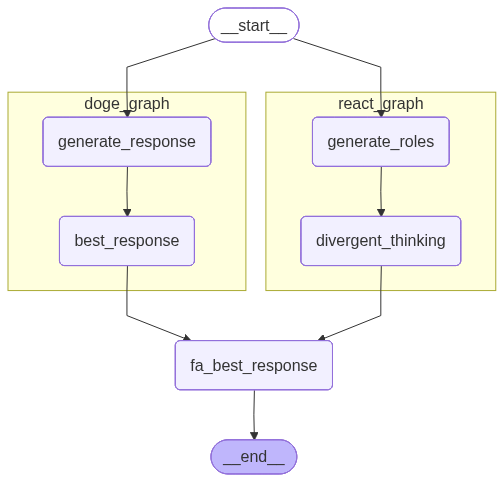

In [15]:
# Parent graph global Schema
class EntryGraphState(TypedDict):
    roles: list[str]
    n: int
    new_roles: list[str]
    responses: Annotated[list, operator.add]
    best_response: str

# Parent graph best response node: return best response and aggregate roles
def fa_best_response(state: EntryGraphState):
    responses = "\n\n".join(state["responses"])
    prompt = best_response_prompt.format(responses=responses)
    response = llm.with_structured_output(BestResponse).invoke(prompt)
    return {
        "roles": state["roles"] + state["new_roles"],
        "best_response": state["responses"][response.id]
    }

# Create parent graph
fa_builder = StateGraph(EntryGraphState)

# Add nodes
fa_builder.add_node("doge_graph", doge_builder.compile())
fa_builder.add_node("react_graph", react_builder.compile())
fa_builder.add_node("fa_best_response", fa_best_response)

# Add edges
fa_builder.add_edge(START, "doge_graph")
fa_builder.add_edge(START, "react_graph")
fa_builder.add_edge("doge_graph", "fa_best_response")
fa_builder.add_edge("react_graph", "fa_best_response")
fa_builder.add_edge("fa_best_response", END)

# Compile graph
fa_graph = fa_builder.compile(name='father-graph')

# Set xray parameter to 1 to display nested graph internal structure
display(Image(fa_graph.get_graph(xray=1).draw_mermaid_png()))

In [16]:
# Invoke graph
response = fa_graph.invoke({"roles": roles[3:6], "n": 5})

The best response here is the best response generated from all responses of the two sub-graphs. Do you think its quality has improved? ( ﾟ∀。)

In [17]:
# Best response
print(f"Most liked reply by {model_name}: {response['best_response']}")

Most liked reply by qwen3-max: I hope I didn’t say anything awkward—just wanted to check in gently, no rush at all to reply!


In [18]:
# All responses
assert len(response["roles"]) == len(response["responses"]), f'{len(response["roles"])} != {len(response["responses"])}'

for role, resp in zip(response["roles"], response["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【Playboy】
Guess even goddesses need a little more charm to respond—should I send another lightning bolt or just keep waiting like a mortal?

【Baby-faced Brother】
Goddess, your silence is more enchanting than words—but I’ll keep waiting, just in case you’re testing my devotion.

【Socially Anxious Homebody】
I hope I didn’t say anything awkward—just wanted to check in gently, no rush at all to reply!

【Playboy】
Guess even goddesses need a little more charm to respond—should I send my halo or just keep waiting with a smile?

【Baby-faced Brother】
Goddess, your silence is more enchanting than words—but I’ll keep waiting, just in case you’re testing my devotion.

【Socially Anxious Homebody】
I hope I didn’t overstep—just wanted to say I’m still here, quietly admiring from afar.

【Mysterious Artist】
Silence, too, is a brushstroke in the canvas of our conversation—shall I wait for your next hue, or paint my own?

【Devoted Scholar】
O Radiant One, your silence is a sacred mystery I shall contempla